# Импорт

In [1]:
import requests
import pandas as pd
import numpy as np
import pickle
import json
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from fbprophet import Prophet
from fbprophet.serialize import model_to_json, model_from_json
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from lightgbm import Dataset, train
from tqdm import tqdm

# Глобальные определения и функции

In [2]:
seed = 110894

In [3]:
UUID = open('uuid.txt').read()
UUID

'91344b932974425eba12ac7112e4ea4e'

In [4]:
class Model(object):
    def predict(self, data: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError
    
    def feedback(self, feedback: pd.DataFrame):
        raise NotImplementedError

###### Функции для работы с сервером

In [5]:
def server_start():
    URL_BEGIN_DATA = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/begin'
    req = requests.post(URL_BEGIN_DATA.format(uuid=UUID))
    return req.json()

def get_batch():
    URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
    response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))
    return response.json()
    
def send_submit(df_submit):
    df_submit['dates'] = df_submit['dates'].apply(str)
    df_submit = (
        df_submit
        .astype({
            'SKU': np.int64,
            'user_id': np.int64,
            'price': np.float64,
        })
    )
    URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'
    req = requests.post(
        URL_TASK_RESULT_POST.format(uuid=UUID),
        data=df_submit.to_json(orient='records')
    )
    return req.json()

def get_result():
    URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
    response = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))
    return response.json()

def submit(model: Model):
    assert server_start()['status'] == 'ok'
    i = 0
    while True:
        response = get_batch()
        if (
            isinstance(response, dict) 
            and response['status'] == 'batch processing finished'
        ):
            break

        print(f'Batch #{i}')
        df_batch = pd.read_json(response)
        df_batch['dates'] = pd.to_datetime(df_batch['dates'])

        df_submit = model.predict(df_batch.copy())

        response = send_submit(df_submit)
        if response['status'] == 'ok':
            df_result = pd.read_json(get_result())
            model.feedback(df_result)
        i += 1

    print('Done!')

# Prophet + LightGBM

In [6]:
df_transactions = pd.read_csv('data/transactions.csv')
df_transactions['dates'] = pd.to_datetime(df_transactions['dates'])
df_transactions.head()

,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0
2,2018-11-09,16019,19074,1252.0
3,2018-11-09,16019,34472,1252.0
4,2018-11-10,16019,48407,1252.0


In [7]:
df_promo = pd.read_csv('data/promo_df.csv')
df_promo.head()

,SKU,week_num,year,discount
0,74430,1,2018,0.15
1,69978,1,2018,0.05
2,81955,1,2018,0.15
3,78953,1,2018,0.10
4,43034,1,2018,0.05


In [8]:
df_canc = pd.read_csv('data/canc_df.csv')
df_canc.head()

,year,week_num,SKU,ret_net_1_price,ret_net_2_price,ret_net_3_price
0,2019,1,10121,2945.681342,2965.743797,2917.394830
1,2019,1,10290,949.466060,942.301292,962.799009
2,2019,1,10973,3751.515022,3735.814981,3709.586540
3,2019,1,11179,3717.042306,3638.799082,3695.090121
4,2019,1,11680,1378.797669,1325.251312,1363.707489


In [9]:
df_transactions_cor = (
    df_transactions
    .merge(
        df_promo,
        how='left',
        left_on=[
            'SKU',
            df_transactions['dates'].dt.year.values,
            df_transactions['dates'].dt.isocalendar().week.values,
        ],
        right_on=['SKU', 'year', 'week_num'],
        validate='m:1',
    )
)
df_transactions_cor.head()

,dates,SKU,user,price,week_num,year,discount
0,2018-11-09,16019,44796,1252.0,45,2018,0.05
1,2018-11-09,16019,44510,1252.0,45,2018,0.05
2,2018-11-09,16019,19074,1252.0,45,2018,0.05
3,2018-11-09,16019,34472,1252.0,45,2018,0.05
4,2018-11-10,16019,48407,1252.0,45,2018,0.05


In [10]:
df_transactions_cor['discount'] = df_transactions_cor['discount'].fillna(0.0)
df_transactions_cor['true_price'] = df_transactions_cor['price'] / (1.0 - df_transactions_cor['discount'])
assert df_transactions_cor['true_price'].notna().all()

In [11]:
df_transactions_agg = (
    df_transactions_cor
    .groupby(['dates', 'SKU'], as_index=False)
    .agg(
        max_true_price=('true_price', 'max'),
        avg_true_price=('true_price', 'mean'),
        min_true_price=('true_price', 'min'),
        max_price=('price', 'max'),
        avg_price=('price', 'mean'),
        min_price=('price', 'min'),
    )
)
df_transactions_agg.head()

,dates,SKU,max_true_price,avg_true_price,min_true_price,max_price,avg_price,min_price
0,2018-01-01,67369,3607.0,3607.0,3607.0,3607.0,3607.0,3607.0
1,2018-01-02,67369,3607.0,3607.0,3607.0,3607.0,3607.0,3607.0
2,2018-01-03,26629,1126.0,1126.0,1126.0,1126.0,1126.0,1126.0
3,2018-01-03,41262,3473.0,3473.0,3473.0,3473.0,3473.0,3473.0
4,2018-01-03,67369,3607.0,3607.0,3607.0,3607.0,3607.0,3607.0


In [12]:
list_sku = list(df_transactions['SKU'].unique())
len(list_sku)

1000

In [13]:
def process_sku(sku: int):
    df = (
        df_transactions_agg
        .loc[df_transactions_agg['SKU'] == sku, ['dates', 'avg_true_price']]
        .rename(columns={'dates': 'ds', 'avg_true_price': 'y'})
        .sort_values('ds')
    )
    
    mask = df['ds'] <= df['ds'].quantile(0.7)
    df_train = df.loc[mask]
    df_test = df.loc[~mask, ['ds']]
    
    prothet_model = (
        Prophet(
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
            interval_width=0.5,
        )
        .add_country_holidays('RU')
        .add_seasonality(
            name='quarter',
            period=362.25/4,
            fourier_order=5,
            prior_scale=15,
        )
    )
    prothet_model.fit(df_train)
    return prothet_model.predict(df_test)

In [14]:
%%time
results = {}
with ProcessPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(process_sku, sku): sku for sku in list_sku}
    for future in as_completed(futures):
        sku = futures[future]
        try:
            results[sku] = future.result()
        except Exception as exc:
            print(f'{sku} generated an exception: {exc}')

CPU times: user 3.47 s, sys: 610 ms, total: 4.08 s
Wall time: 8min 9s


In [15]:
df_prophets_features = pd.concat(
    [results[sku].assign(SKU=sku) for sku in results],
    ignore_index=True,
)
df_prophets_features.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Defender of the Fatherland Day,...,holidays_lower,holidays_upper,quarter,quarter_lower,quarter_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,SKU
0,2019-09-15,4151.285421,4111.851313,4149.706143,4151.285421,4151.285421,0.0,0.0,0.0,0.0,...,0.0,0.0,-21.502318,-21.502318,-21.502318,0.0,0.0,0.0,4129.783104,30482
1,2019-09-16,4151.008058,4110.034047,4149.405235,4151.008058,4151.008058,0.0,0.0,0.0,0.0,...,0.0,0.0,-19.621155,-19.621155,-19.621155,0.0,0.0,0.0,4131.386903,30482
2,2019-09-17,4150.730695,4110.737304,4150.233703,4150.730695,4150.730695,0.0,0.0,0.0,0.0,...,0.0,0.0,-18.258446,-18.258446,-18.258446,0.0,0.0,0.0,4132.472248,30482
3,2019-09-18,4150.453331,4110.485368,4153.510525,4150.453331,4150.453331,0.0,0.0,0.0,0.0,...,0.0,0.0,-17.733114,-17.733114,-17.733114,0.0,0.0,0.0,4132.720217,30482
4,2019-09-19,4150.175968,4110.673267,4152.241507,4150.175964,4150.175968,0.0,0.0,0.0,0.0,...,0.0,0.0,-18.251925,-18.251925,-18.251925,0.0,0.0,0.0,4131.924043,30482


In [16]:
df_prophets_features = df_prophets_features.loc[:, ['ds', 'SKU', 'yhat']]
df_prophets_features = df_prophets_features.rename(columns={'ds': 'dates', 'yhat': 'prophet_price'})
df_prophets_features.head()

,dates,SKU,prophet_price
0,2019-09-15,30482,4129.783104
1,2019-09-16,30482,4131.386903
2,2019-09-17,30482,4132.472248
3,2019-09-18,30482,4132.720217
4,2019-09-19,30482,4131.924043


In [17]:
df_data = (
    df_transactions_agg
    .loc[:, ['dates', 'SKU', 'avg_price']]
    .merge(df_prophets_features, how='inner', on=['dates', 'SKU'])
)
df_data.head()

,dates,SKU,avg_price,prophet_price
0,2018-02-24,76032,4350.0,4387.229297
1,2018-02-25,76032,4350.0,4400.371964
2,2018-02-26,76032,4361.0,4392.387516
3,2018-02-27,76032,4361.0,4342.460691
4,2018-02-28,76032,4361.0,4224.837461


In [18]:
df_data['year'] = df_data['dates'].dt.year
df_data['week_num'] = df_data['dates'].dt.isocalendar().week

In [19]:
df_canc['max_canc_price'] = (
    np.stack(
        [
            df_canc['ret_net_1_price'],
            df_canc['ret_net_2_price'],
            df_canc['ret_net_3_price']
        ],
        axis=1,
    )
    .max(axis=1)
)

In [20]:
df_data = (
    df_data
    .merge(
        df_promo,
        how='left',
        on=['SKU', 'year', 'week_num'],
        validate='m:1',
    )
    .merge(
        df_canc,
        how='left',
        on=['SKU', 'year', 'week_num'],
        validate='m:1',
    )
)
df_data.head()

,dates,SKU,avg_price,prophet_price,year,week_num,discount,ret_net_1_price,ret_net_2_price,ret_net_3_price,max_canc_price
0,2018-02-24,76032,4350.0,4387.229297,2018,8,NaN,NaN,NaN,NaN,NaN
1,2018-02-25,76032,4350.0,4400.371964,2018,8,NaN,NaN,NaN,NaN,NaN
2,2018-02-26,76032,4361.0,4392.387516,2018,9,NaN,NaN,NaN,NaN,NaN
3,2018-02-27,76032,4361.0,4342.460691,2018,9,NaN,NaN,NaN,NaN,NaN
4,2018-02-28,76032,4361.0,4224.837461,2018,9,NaN,NaN,NaN,NaN,NaN


In [21]:
df_data = df_data.fillna(0.0)

In [22]:
list_features = [
    'prophet_price',
    'discount',
    'max_canc_price',
]

In [23]:
X = df_data.loc[:, list_features]
y = df_data.loc[:, 'avg_price']

In [24]:
(
    X_train, X_tmp,
    y_train, y_tmp,
) = train_test_split(
    X, y,
    test_size=0.35,
    random_state=seed,
)
(
    X_valid, X_test,
    y_valid, y_test,
) = train_test_split(
    X_tmp, y_tmp,
    test_size=0.5,
    random_state=seed,
)
X_train.shape, X_valid.shape, X_test.shape

((62295, 3), (16772, 3), (16772, 3))

In [25]:
lgb_train = Dataset(data=X_train, label=y_train)
lgb_valid = Dataset(data=X_test, label=y_test, reference=lgb_train)
lgb_model = train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'seed': seed,
        'verbosity': -1,
    },
    train_set=lgb_train,
    num_boost_round=100_000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=100,
    verbose_eval=100,
)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 213.771	valid's rmse: 214.412
[200]	train's rmse: 212.871	valid's rmse: 213.315
[300]	train's rmse: 212.535	valid's rmse: 212.889
[400]	train's rmse: 212.371	valid's rmse: 212.671
[500]	train's rmse: 212.246	valid's rmse: 212.525
[600]	train's rmse: 212.155	valid's rmse: 212.421
[700]	train's rmse: 212.09	valid's rmse: 212.356
[800]	train's rmse: 212.041	valid's rmse: 212.318
[900]	train's rmse: 212.006	valid's rmse: 212.275
[1000]	train's rmse: 211.97	valid's rmse: 212.255
Early stopping, best iteration is:
[976]	train's rmse: 211.981	valid's rmse: 212.249


In [26]:
df_pred = df_data.loc[X_test.index, ['dates', 'SKU', 'avg_price', 'prophet_price']]
df_pred['lgb_price'] = lgb_model.predict(X_test)
df_pred.head()

,dates,SKU,avg_price,prophet_price,lgb_price
88591,2019-11-21,89727,4366.0,4482.651919,4329.273631
28350,2019-08-11,74578,1746.0,1746.973269,1735.665077
26538,2019-08-06,92847,925.0,1100.499398,1173.515685
56478,2019-10-07,46354,4410.0,4502.797202,4407.368323
93591,2019-11-28,25684,2335.0,1487.484515,2267.388560


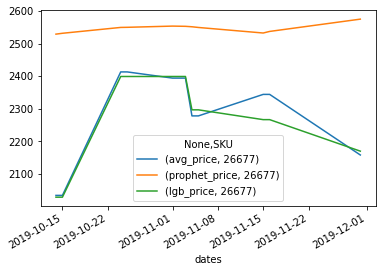

In [27]:
df_pred[df_pred['SKU'] == 26677].pivot(index='dates', columns='SKU', values=df_pred.columns[2:]).plot()

In [28]:
batches = {}

In [29]:
def prophet_predict(df_batch: pd.DataFrame, sku: int) -> pd.DataFrame:
    df_train = (
        df_transactions_agg
        .loc[df_transactions_agg['SKU'] == sku, ['dates', 'avg_true_price']]
        .rename(columns={'dates': 'ds', 'avg_true_price': 'y'})
        .sort_values('ds')
    )
    
    df_test = df_batch.loc[df_batch['SKU'] == sku, ['dates']]
    df_test.columns = ['ds']
    
    prothet_model = (
        Prophet(
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
            interval_width=0.5,
        )
        .add_country_holidays('RU')
        .add_seasonality(
            name='quarter',
            period=362.25/4,
            fourier_order=5,
            prior_scale=15,
        )
    )
    prothet_model.fit(df_train)
    return prothet_model.predict(df_test)

In [35]:
assert server_start()['status'] == 'ok'
i = 0
while True:
    response = get_batch()
    if (
        isinstance(response, dict) 
        and response['status'] == 'batch processing finished'
    ):
        break
    print(f'Batch #{i}')
    df_batch = pd.read_json(response)
    df_batch['dates'] = pd.to_datetime(df_batch['dates'])
    print(df_batch.shape)
    
    df_data = df_batch[['dates', 'SKU']].drop_duplicates(['dates', 'SKU'])
    print(df_data.shape)
    
    list_sku = list(df_data['SKU'].unique())    
    results = {}
    with ProcessPoolExecutor(max_workers=5) as executor:
        futures = {executor.submit(prophet_predict, df_data, sku): sku for sku in list_sku}
        for future in as_completed(futures):
            sku = futures[future]
            try:
                results[sku] = future.result()
            except Exception as exc:
                print(f'{sku} generated an exception: {exc}')
    
    df_prophets_features = pd.concat(
        [results[sku].assign(SKU=sku) for sku in results],
        ignore_index=True,
    )
    df_prophets_features = df_prophets_features.loc[:, ['ds', 'SKU', 'yhat']]
    df_prophets_features = df_prophets_features.rename(columns={'ds': 'dates', 'yhat': 'prophet_price'})
    del results
    
    df_data = (
        df_data
        .merge(df_prophets_features, how='inner', on=['dates', 'SKU'])
    )
    df_data['year'] = df_data['dates'].dt.year
    df_data['week_num'] = df_data['dates'].dt.isocalendar().week    
    df_data = (
        df_data
        .merge(
            df_promo,
            how='left',
            on=['SKU', 'year', 'week_num'],
            validate='m:1',
        )
        .merge(
            df_canc,
            how='left',
            on=['SKU', 'year', 'week_num'],
            validate='m:1',
        )
    )
    df_data = df_data.fillna(0.0)
    print(df_data.shape)
    
    df_data['price'] = lgb_model.predict(df_data[list_features])
    
    df_batch = df_batch.merge(df_data[['dates', 'SKU', 'price']], how='inner', on=['dates', 'SKU'])
    del df_data
    print(df_batch.shape)
    
    response = send_submit(df_batch)
    if response['status'] == 'ok':
        df_result = pd.read_json(get_result())
    i += 1
print('Done!')

Batch #0
(9737, 3)
(826, 2)
(826, 10)
(9737, 4)
Batch #1
(9738, 3)
(826, 2)
(826, 10)
(9738, 4)
Batch #2
(9735, 3)
(826, 2)
(826, 10)
(9735, 4)
Batch #3
(9738, 3)
(826, 2)
(826, 10)
(9738, 4)
Batch #4
(9738, 3)
(826, 2)
(826, 10)
(9738, 4)
Batch #5
(9739, 3)
(826, 2)
(826, 10)
(9739, 4)
Batch #6
(9739, 3)
(826, 2)
(826, 10)
(9739, 4)
Batch #7
(9720, 3)
(824, 2)
(824, 10)
(9720, 4)
Batch #8
(9697, 3)
(822, 2)
(822, 10)
(9697, 4)
Batch #9
(9698, 3)
(822, 2)
(822, 10)
(9698, 4)
Batch #10
(9694, 3)
(822, 2)
(822, 10)
(9694, 4)
Batch #11
(9686, 3)
(820, 2)
(820, 10)
(9686, 4)
Batch #12
(9668, 3)
(819, 2)
(819, 10)
(9668, 4)
Batch #13
(9673, 3)
(819, 2)
(819, 10)
(9673, 4)
Batch #14
(9669, 3)
(819, 2)
(819, 10)
(9669, 4)
Batch #15
(9655, 3)
(818, 2)
(818, 10)
(9655, 4)
Batch #16
(9658, 3)
(818, 2)
(818, 10)
(9658, 4)
Batch #17
(9658, 3)
(818, 2)
(818, 10)
(9658, 4)
Batch #18
(9656, 3)
(818, 2)
(818, 10)
(9656, 4)
Batch #19
(9631, 3)
(816, 2)
(816, 10)
(9631, 4)
Batch #20
(9634, 3)
(816, 2)
(

# Базовый подход

## Готовим данные

In [7]:
df_transactions = pd.read_csv('data/transactions.csv')
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334260 entries, 0 to 1334259
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   dates   1334260 non-null  object 
 1   SKU     1334260 non-null  int64  
 2   user    1334260 non-null  int64  
 3   price   1334260 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 40.7+ MB


In [8]:
df_transactions['dates'] = pd.to_datetime(df_transactions['dates'])
df_transactions.head()

,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0
2,2018-11-09,16019,19074,1252.0
3,2018-11-09,16019,34472,1252.0
4,2018-11-10,16019,48407,1252.0


In [9]:
df_transactions_agg = (
    df_transactions
    .groupby(['dates', 'SKU'], as_index=False)
    .agg(
        price=('price', 'mean'),
    )
)
df_transactions_agg.head()

,dates,SKU,price
0,2018-01-01,67369,3607.0
1,2018-01-02,67369,3607.0
2,2018-01-03,26629,1126.0
3,2018-01-03,41262,3473.0
4,2018-01-03,67369,3607.0


In [10]:
n_lags = 12

In [11]:
df_data = df_transactions_agg.copy()
for n_lag in range(1, n_lags):
    df_data[f'lag_{n_lag}_price'] = df_transactions_agg.groupby('SKU')['price'].shift(n_lag)
df_data.head()

,dates,SKU,price,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_6_price,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price
0,2018-01-01,67369,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,67369,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,26629,1126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-03,41262,3473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-03,67369,3607.0,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_data['week_num'] = df_data['dates'].dt.week.astype('category')
df_data['dates_int'] = df_data['dates'].astype(int)
df_data.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


,dates,SKU,price,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_6_price,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price,week_num,dates_int
0,2018-01-01,67369,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1514764800000000000
1,2018-01-02,67369,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1514851200000000000
2,2018-01-03,26629,1126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1514937600000000000
3,2018-01-03,41262,3473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1514937600000000000
4,2018-01-03,67369,3607.0,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1514937600000000000


In [13]:
df_data['dates_int'].min(), df_data['dates_int'].max()

(1514764800000000000, 1575072000000000000)

In [14]:
df_data['dates_int'] = (df_data['dates_int'] - 1514764800000000000) / (1575072000000000000 - 1514764800000000000)
df_data.head()

,dates,SKU,price,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_6_price,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price,week_num,dates_int
0,2018-01-01,67369,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.000000
1,2018-01-02,67369,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.001433
2,2018-01-03,26629,1126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865
3,2018-01-03,41262,3473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865
4,2018-01-03,67369,3607.0,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865


In [15]:
df_data['q'] = df_data['SKU'].map(df_data.groupby('SKU').agg(q=('dates', lambda x: x.quantile(0.70)))['q'])
df_data.head()

,dates,SKU,price,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_6_price,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price,week_num,dates_int,q
0,2018-01-01,67369,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.000000,2019-05-04 14:24:00
1,2018-01-02,67369,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.001433,2019-05-04 14:24:00
2,2018-01-03,26629,1126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865,2018-03-12 14:24:00
3,2018-01-03,41262,3473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865,2019-05-05 04:48:00
4,2018-01-03,67369,3607.0,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865,2019-05-04 14:24:00


In [16]:
list_features = [
    'week_num',
    'dates_int',
]
list_features += [f'lag_{i}_price' for i in range(1, n_lags)]
list_features

['week_num',
 'dates_int',
 'lag_1_price',
 'lag_2_price',
 'lag_3_price',
 'lag_4_price',
 'lag_5_price',
 'lag_6_price',
 'lag_7_price',
 'lag_8_price',
 'lag_9_price',
 'lag_10_price',
 'lag_11_price']

In [17]:
mask = df_data['dates'] <= df_data['q']

In [18]:
X_train = df_data.loc[mask, list_features]
y_train = df_data.loc[mask, 'price']
X_valid = df_data.loc[~mask, list_features]
y_valid = df_data.loc[~mask, 'price']
X_train.shape, X_valid.shape

((223117, 13), (95839, 13))

In [19]:
lgb_train = Dataset(data=X_train, label=y_train)
lgb_valid = Dataset(data=X_valid, label=y_valid, reference=lgb_train)
lgb_model = train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'seed': seed,
        'verbosity': -1,
    },
    train_set=lgb_train,
    num_boost_round=100_000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=100,
    verbose_eval=100,
)

/home/jupyter-v.pashentsev-2/.local/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/jupyter-v.pashentsev-2/.local/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 81.3176	valid's rmse: 24.8508
[200]	train's rmse: 78.6273	valid's rmse: 24.996
Early stopping, best iteration is:
[116]	train's rmse: 80.9202	valid's rmse: 24.8169


## Тестируем

In [20]:
df_base = df_transactions_agg.copy()
df_work = df_base.copy()

In [21]:
server_start()

{'status': 'ok'}

In [29]:
df_batch = pd.read_json(get_batch())
df_batch.head()

,dates,SKU,user_id
0,2019-12-02,30482,45542
1,2019-12-02,16390,44335
2,2019-12-02,32801,32957
3,2019-12-02,56252,14196
4,2019-12-02,11801,16227


In [30]:
df_batch['dates'] = pd.to_datetime(df_batch['dates'])

In [31]:
df_work = pd.concat([df_work[['dates', 'SKU', 'price']], df_batch.drop_duplicates(['dates', 'SKU'])], ignore_index=True)

for n_lag in range(1, n_lags):
    df_work[f'lag_{n_lag}_price'] = df_work.groupby('SKU')['price'].shift(n_lag)

df_work['week_num'] = df_work['dates'].dt.week.astype('category')
df_work['dates_int'] = df_work['dates'].astype(int)
df_work['dates_int'] = (df_work['dates_int'] - 1514764800000000000) / (1575072000000000000 - 1514764800000000000)

df_work.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,dates,SKU,price,user_id,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_6_price,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price,week_num,dates_int
0,2018-01-01,67369,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.000000
1,2018-01-02,67369,3607.0,NaN,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.001433
2,2018-01-03,26629,1126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865
3,2018-01-03,41262,3473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865
4,2018-01-03,67369,3607.0,NaN,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.002865


In [32]:
mask = df_work['price'].isna()
df_work.loc[mask, 'price'] = lgb_model.predict(df_work.loc[mask, list_features])

In [33]:
df_submit = df_batch.merge(df_work[['dates', 'SKU', 'price']], how='left', on=['dates', 'SKU'])
df_submit.head()

,dates,SKU,user_id,price
0,2019-12-02,30482,45542,4179.691503
1,2019-12-02,16390,44335,1289.946778
2,2019-12-02,32801,32957,928.902737
3,2019-12-02,56252,14196,4093.492456
4,2019-12-02,11801,16227,1727.463117


In [34]:
send_submit(df_submit)

{'status': 'ok'}

In [35]:
df_result = pd.read_json(get_result())
df_result.head()

,dates,SKU,user_id,price,bought
0,2019-12-01,16019,20585,1135.723941,1
1,2019-12-01,93657,38019,2491.039644,0
2,2019-12-01,84011,27418,4522.426890,1
3,2019-12-01,84011,44258,4522.426890,0
4,2019-12-01,29011,63229,2547.653548,0


## Отправляем результат

In [37]:
class BaselineModel(Model):
    def __init__(self, df_work: pd.DataFrame, list_features, lgb_model):
        self.df_work = df_work.copy()
        self.list_features = list_features
        self.lgb_model = lgb_model
        
    def predict(self, data: pd.DataFrame) -> pd.DataFrame:
        
        self.df_work = (
            pd.concat(
                [
                    self.df_work[['dates', 'SKU', 'price']],
                    data.drop_duplicates(['dates', 'SKU']),
                ],
                ignore_index=True,
            )
        )

        for n_lag in range(1, n_lags):
            self.df_work[f'lag_{n_lag}_price'] = self.df_work.groupby('SKU')['price'].shift(n_lag)

        self.df_work['week_num'] = self.df_work['dates'].dt.week.astype('category')
        self.df_work['dates_int'] = self.df_work['dates'].astype(int)
        self.df_work['dates_int'] = (self.df_work['dates_int'] - 1514764800000000000) / (1575072000000000000 - 1514764800000000000)

        mask = self.df_work['price'].isna()
        self.df_work.loc[mask, 'price'] = self.lgb_model.predict(self.df_work.loc[mask, self.list_features])
        
        return data.merge(self.df_work[['dates', 'SKU', 'price']], how='left', on=['dates', 'SKU'])

In [38]:
submit(BaselineModel(df_transactions_agg, list_features, lgb_model))

Batch #0


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #1


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #2


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #3


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #4


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #5


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #6


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #7


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #8


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #9


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #10


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #11


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #12


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #13


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #14


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #15


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #16


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #17


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #18


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #19


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #20


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #21


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #22


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #23


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #24


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #25


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #26


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #27


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #28


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #29


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Done!


# Добавляем фичи по пользователям, промо и конкурентам

## Готовим данные

In [61]:
df_transactions = pd.read_csv('data/transactions.csv')
df_transactions['dates'] = pd.to_datetime(df_transactions['dates'])
df_promo = pd.read_csv('data/promo_df.csv')
df_canc = pd.read_csv('data/canc_df.csv')

In [62]:
df_data = df_transactions.loc[:, ['dates', 'SKU', 'user']]
df_data.head()

,dates,SKU,user
0,2018-11-09,16019,44796
1,2018-11-09,16019,44510
2,2018-11-09,16019,19074
3,2018-11-09,16019,34472
4,2018-11-10,16019,48407


In [63]:
df_grouped = (
    df_transactions
    .groupby(['dates', 'user'], as_index=False)
    .agg(price=('price', 'mean'))
    .sort_values(['dates', 'user'])
    .groupby('user')
)
df_window_6 = df_grouped.rolling(6, min_periods=1, on='dates')

df_users_agg = pd.concat(
    [
        df_window_6['price'].max(),
        df_window_6['price'].min(),
        df_window_6['price'].mean(),
    ],
    axis=1,
)
df_users_agg.columns = ['max_price', 'min_price', 'mean_price']
df_users_agg = df_users_agg.reset_index()
df_users_agg.head()

,user,dates,max_price,min_price,mean_price
0,10002,2018-03-22,691.0,691.0,691.0
1,10002,2018-04-19,2014.0,691.0,1352.5
2,10002,2018-06-15,2014.0,301.0,1002.0
3,10002,2018-06-25,2014.0,301.0,1138.5
4,10002,2018-07-08,3494.0,301.0,1609.6


In [64]:
df_sku_agg = (
    df_transactions
    .groupby(['dates', 'SKU'], as_index=False)
    .agg(
        price=('price', 'mean'),
    )
)
for i in range(0, 12):
    n_lag = i+1
    df_sku_agg[f'lag_{n_lag}_price'] = df_sku_agg.groupby('SKU')['price'].shift(n_lag)
df_sku_agg.head()

,dates,SKU,price,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_6_price,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price,lag_12_price
0,2018-01-01,67369,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,67369,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,26629,1126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-03,41262,3473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-03,67369,3607.0,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df_data['year'] = df_data['dates'].dt.year.astype('category')
df_data['week_num'] = df_data['dates'].dt.week.astype('category')
df_data['dates_int'] = df_data['dates'].astype(int)
df_data.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,dates,SKU,user,year,week_num,dates_int
0,2018-11-09,16019,44796,2018,45,1541721600000000000
1,2018-11-09,16019,44510,2018,45,1541721600000000000
2,2018-11-09,16019,19074,2018,45,1541721600000000000
3,2018-11-09,16019,34472,2018,45,1541721600000000000
4,2018-11-10,16019,48407,2018,45,1541808000000000000


In [66]:
df_data = (
    df_data
    .merge(
        df_users_agg,
        how='left',
        on=['dates', 'user'],
    )
    .merge(
        df_sku_agg,
        how='left',
        on=['dates', 'SKU'],
    )
    .merge(
        df_promo,
        how='left',
        on=['year', 'week_num', 'SKU'],
    )
    .merge(
        df_canc,
        how='left',
        on=['year', 'week_num', 'SKU'],
    )
)
df_data.head()

,dates,SKU,user,year,week_num,dates_int,max_price,min_price,mean_price,price,...,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price,lag_12_price,discount,ret_net_1_price,ret_net_2_price,ret_net_3_price
0,2018-11-09,16019,44796,2018,45,1541721600000000000,3431.0,1252.0,2120.500000,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN
1,2018-11-09,16019,44510,2018,45,1541721600000000000,3392.0,401.0,2046.000000,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN
2,2018-11-09,16019,19074,2018,45,1541721600000000000,3399.0,429.0,1950.611111,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN
3,2018-11-09,16019,34472,2018,45,1541721600000000000,4225.0,1252.0,2731.666667,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN
4,2018-11-10,16019,48407,2018,45,1541808000000000000,3907.0,1252.0,2347.000000,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN


In [67]:
df_data.shape

(1334260, 26)

In [68]:
df_data['dates_int'].min(), df_data['dates_int'].max()

(1514764800000000000, 1575072000000000000)

In [69]:
df_data['dates_int'] = (df_data['dates_int'] - 1514764800000000000) / (1575072000000000000 - 1514764800000000000)
df_data.head()

,dates,SKU,user,year,week_num,dates_int,max_price,min_price,mean_price,price,...,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price,lag_12_price,discount,ret_net_1_price,ret_net_2_price,ret_net_3_price
0,2018-11-09,16019,44796,2018,45,0.446991,3431.0,1252.0,2120.500000,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN
1,2018-11-09,16019,44510,2018,45,0.446991,3392.0,401.0,2046.000000,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN
2,2018-11-09,16019,19074,2018,45,0.446991,3399.0,429.0,1950.611111,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN
3,2018-11-09,16019,34472,2018,45,0.446991,4225.0,1252.0,2731.666667,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN
4,2018-11-10,16019,48407,2018,45,0.448424,3907.0,1252.0,2347.000000,1252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN


In [70]:
df_data['q'] = df_data['SKU'].map(df_data.groupby('SKU').agg(q=('dates', lambda x: x.quantile(0.70)))['q'])
df_data.head()

,dates,SKU,user,year,week_num,dates_int,max_price,min_price,mean_price,price,...,lag_8_price,lag_9_price,lag_10_price,lag_11_price,lag_12_price,discount,ret_net_1_price,ret_net_2_price,ret_net_3_price,q
0,2018-11-09,16019,44796,2018,45,0.446991,3431.0,1252.0,2120.500000,1252.0,...,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,2019-07-31
1,2018-11-09,16019,44510,2018,45,0.446991,3392.0,401.0,2046.000000,1252.0,...,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,2019-07-31
2,2018-11-09,16019,19074,2018,45,0.446991,3399.0,429.0,1950.611111,1252.0,...,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,2019-07-31
3,2018-11-09,16019,34472,2018,45,0.446991,4225.0,1252.0,2731.666667,1252.0,...,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,2019-07-31
4,2018-11-10,16019,48407,2018,45,0.448424,3907.0,1252.0,2347.000000,1252.0,...,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,2019-07-31


In [71]:
list_features = df_data.columns[~df_data.columns.isin(['dates', 'SKU', 'user', 'price', 'q'])]
list_features

Index(['year', 'week_num', 'dates_int', 'max_price', 'min_price', 'mean_price',
       'lag_1_price', 'lag_2_price', 'lag_3_price', 'lag_4_price',
       'lag_5_price', 'lag_6_price', 'lag_7_price', 'lag_8_price',
       'lag_9_price', 'lag_10_price', 'lag_11_price', 'lag_12_price',
       'discount', 'ret_net_1_price', 'ret_net_2_price', 'ret_net_3_price'],
      dtype='object')

In [72]:
mask = df_data['dates'] <= df_data['q']

In [73]:
X_train = df_data.loc[mask, list_features]
y_train = df_data.loc[mask, 'price']
X_valid = df_data.loc[~mask, list_features]
y_valid = df_data.loc[~mask, 'price']
X_train.shape, X_valid.shape

((935437, 22), (398823, 22))

In [74]:
lgb_train = Dataset(data=X_train, label=y_train)
lgb_valid = Dataset(data=X_valid, label=y_valid, reference=lgb_train)
lgb_model = train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'seed': seed,
        'verbosity': -1,
    },
    train_set=lgb_train,
    num_boost_round=100_000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=100,
    verbose_eval=100,
)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 63.9908	valid's rmse: 23.6694
[200]	train's rmse: 57.2869	valid's rmse: 23.7104
Early stopping, best iteration is:
[110]	train's rmse: 62.8529	valid's rmse: 23.6116


## Тестируем

In [75]:
df_base = df_transactions.copy()
df_base['bought'] = 1
df_base.shape

(1334260, 5)

In [76]:
server_start()

{'status': 'ok'}

In [77]:
df_base.shape

(1334260, 5)

In [78]:
df_batch = pd.read_json(get_batch())
df_batch['dates'] = pd.to_datetime(df_batch['dates'])
df_batch = df_batch.rename(columns={'user_id': 'user'})
df_batch.shape

(9739, 3)

In [79]:
df_data = pd.concat([df_base, df_batch], ignore_index=True)
df_data.shape

(1343999, 5)

In [80]:
df_sku = (
    df_data
    .groupby(['dates', 'SKU'], as_index=False)
    .agg(price=('price', 'mean'))
)
for i in range(0, 12):
    n_lag = i+1
    df_sku[f'lag_{n_lag}_price'] = df_sku.groupby('SKU')['price'].shift(n_lag)
df_sku = df_sku.drop(columns=['price'])
df_sku.head()

,dates,SKU,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_6_price,lag_7_price,lag_8_price,lag_9_price,lag_10_price,lag_11_price,lag_12_price
0,2018-01-01,67369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,67369,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,26629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-03,41262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-03,67369,3607.0,3607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
df_grouped = (
    df_data
    .loc[df_data['bought'] == 1]
    .groupby(['dates', 'user'], as_index=False)
    .agg(price=('price', 'mean'))
    .sort_values(['dates', 'user'])
    .groupby('user')
)
df_window_6 = df_grouped.rolling(6, min_periods=1, on='dates')

df_user = pd.concat(
    [
        df_window_6['price'].max(),
        df_window_6['price'].min(),
        df_window_6['price'].mean(),
    ],
    axis=1,
)
df_user.columns = ['max_price', 'min_price', 'mean_price']
df_user = df_user.reset_index()
df_user.head()

,user,dates,max_price,min_price,mean_price
0,10002,2018-03-22,691.0,691.0,691.0
1,10002,2018-04-19,2014.0,691.0,1352.5
2,10002,2018-06-15,2014.0,301.0,1002.0
3,10002,2018-06-25,2014.0,301.0,1138.5
4,10002,2018-07-08,3494.0,301.0,1609.6


In [82]:
df_data['year'] = df_data['dates'].dt.year.astype('category')
df_data['week_num'] = df_data['dates'].dt.week.astype('category')
df_data['dates_int'] = df_data['dates'].astype(int)
df_data['dates_int'] = (df_data['dates_int'] - 1514764800000000000) / (1575072000000000000 - 1514764800000000000)
df_data.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,dates,SKU,user,price,bought,year,week_num,dates_int
0,2018-11-09,16019,44796,1252.0,1.0,2018,45,0.446991
1,2018-11-09,16019,44510,1252.0,1.0,2018,45,0.446991
2,2018-11-09,16019,19074,1252.0,1.0,2018,45,0.446991
3,2018-11-09,16019,34472,1252.0,1.0,2018,45,0.446991
4,2018-11-10,16019,48407,1252.0,1.0,2018,45,0.448424


In [83]:
df_user.shape[0] == df_user.drop_duplicates(['dates', 'user']).shape[0]

True

In [84]:
df_sku.shape[0] == df_sku.drop_duplicates(['dates', 'SKU']).shape[0]

True

In [85]:
df_data = (
    df_data
    .merge(
        df_user,
        how='left',
        on=['dates', 'user'],
    )
    .merge(
        df_sku,
        how='left',
        on=['dates', 'SKU'],
    )
    .merge(
        df_promo,
        how='left',
        on=['year', 'week_num', 'SKU'],
    )
    .merge(
        df_canc,
        how='left',
        on=['year', 'week_num', 'SKU'],
    )
)
df_data.shape

(1343999, 27)

In [86]:
df_data.shape[0] == (df_base.shape[0] + df_batch.shape[0])

True

In [87]:
mask = df_data['price'].isna()
df_data.loc[mask, 'price'] = lgb_model.predict(df_data.loc[mask, list_features])

In [88]:
df_submit = df_batch.merge(df_data[['dates', 'SKU', 'user', 'price']], how='left', on=['dates', 'SKU', 'user'])
df_submit = df_submit.rename(columns={'user': 'user_id'})
df_submit.head()

,dates,SKU,user_id,price
0,2019-12-01,16019,27822,1130.440289
1,2019-12-01,84011,60133,4534.696757
2,2019-12-01,84011,13021,4534.696757
3,2019-12-01,29011,36337,2553.717391
4,2019-12-01,79558,25147,2938.085874


In [89]:
send_submit(df_submit)

{'status': 'ok'}

In [90]:
df_result = pd.read_json(get_result())
df_result['dates'] = pd.to_datetime(df_result['dates'])
df_result = df_result.rename(columns={'user_id': 'user'})
df_result.head()

,dates,SKU,user,price,bought
0,2019-12-01,16019,27822,1130.440289,0
1,2019-12-01,84011,60133,4534.696757,0
2,2019-12-01,84011,13021,4534.696757,0
3,2019-12-01,29011,36337,2553.717391,0
4,2019-12-01,79558,25147,2938.085874,0


In [91]:
df_base = (
    df_data
    .merge(
        df_result,
        how='left',
        on=list(df_result.columns[:-2]),
        suffixes=('', '_'),
    )
    .assign(bought=lambda X: np.where(X['bought'].isna(),X['bought_'], X['bought']))
    .loc[:, df_result.columns]
)
(df_base['bought'] != 1).sum()

5764

In [92]:
df_base.shape, df_submit.shape

((1343999, 5), (9739, 4))

In [93]:
del df_user, df_sku, df_data, df_result

In [94]:
import gc
gc.collect()

80

## Отправляем результат

In [95]:
class MoreFeaturesModel(Model):
    def __init__(self, df_base: pd.DataFrame, list_features, lgb_model, df_promo, df_canc):
        self.df_base = df_base
        self.df_base['bought'] = 1
        self.df_data = None
        self.list_features = list_features
        self.lgb_model = lgb_model
        self.df_promo = df_promo
        self.df_canc = df_canc
        
    def predict(self, data: pd.DataFrame) -> pd.DataFrame:
        data = data.rename(columns={'user_id': 'user'})
        self.df_data = pd.concat([self.df_base, data], ignore_index=True)
        
        df_sku = (
            self.df_data
            .groupby(['dates', 'SKU'], as_index=False)
            .agg(price=('price', 'mean'))
        )
        for i in range(0, 12):
            n_lag = i+1
            df_sku[f'lag_{n_lag}_price'] = df_sku.groupby('SKU')['price'].shift(n_lag)
        df_sku = df_sku.drop(columns=['price'])   
        
        df_grouped = (
            self.df_data
            .loc[self.df_data['bought'] == 1]
            .groupby(['dates', 'user'], as_index=False)
            .agg(price=('price', 'mean'))
            .sort_values(['dates', 'user'])
            .groupby('user')
        )
        df_window_6 = df_grouped.rolling(6, min_periods=1, on='dates')
        df_user = pd.concat(
            [
                df_window_6['price'].max(),
                df_window_6['price'].min(),
                df_window_6['price'].mean(),
            ],
            axis=1,
        )
        df_user.columns = ['max_price', 'min_price', 'mean_price']
        df_user = df_user.reset_index()
        
        self.df_data['year'] = self.df_data['dates'].dt.year.astype('category')
        self.df_data['week_num'] = self.df_data['dates'].dt.week.astype('category')
        self.df_data['dates_int'] = self.df_data['dates'].astype(int)
        self.df_data['dates_int'] = (self.df_data['dates_int'] - 1514764800000000000) / (1575072000000000000 - 1514764800000000000)
        
        self.df_data = (
            self.df_data
            .merge(
                df_user,
                how='left',
                on=['dates', 'user'],
            )
            .merge(
                df_sku,
                how='left',
                on=['dates', 'SKU'],
            )
            .merge(
                self.df_promo,
                how='left',
                on=['year', 'week_num', 'SKU'],
            )
            .merge(
                self.df_canc,
                how='left',
                on=['year', 'week_num', 'SKU'],
            )
        )
        
        mask = self.df_data['price'].isna()
        self.df_data.loc[mask, 'price'] = lgb_model.predict(self.df_data.loc[mask, list_features])
        
        df_submit = data.merge(self.df_data[['dates', 'SKU', 'user', 'price']], how='left', on=['dates', 'SKU', 'user'])
        df_submit = df_submit.rename(columns={'user': 'user_id'})
        
        del df_user, df_sku
        
        return df_submit
        
    def feedback(self, feedback: pd.DataFrame):        
        feedback['dates'] = pd.to_datetime(feedback['dates'])
        feedback = feedback.rename(columns={'user_id': 'user'})
        
        self.df_base = (
            self.df_data
            .merge(
                feedback,
                how='left',
                on=list(feedback.columns[:-2]),
                suffixes=('', '_'),
            )
            .assign(bought=lambda X: np.where(X['bought'].isna(),X['bought_'], X['bought']))
            .loc[:, feedback.columns]
        )
        
        self.df_data = None

In [96]:
submit(MoreFeaturesModel(df_transactions.copy(), list_features, lgb_model, df_promo, df_canc))

Batch #0


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #1


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #2


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #3


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #4


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #5


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #6


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #7


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #8


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #9


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #10


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #11


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #12


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #13


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #14


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #15


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #16


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #17


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #18


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #19


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #20


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #21


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #22


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #23


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #24


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #25


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #26


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #27


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #28


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Batch #29


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Done!
